In [1]:
import sys
import pickle
import scipy.io as sio
import numpy as np
import keras.backend as K
from keras.optimizers import SGD
from keras.utils import np_utils
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

Using TensorFlow backend.
/Users/dwright/anaconda2/envs/aind/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
sys.path.insert(0,'/Users/dwright/dev/zoo/machine_augmented_classification/experiments/dissolving/mutitask/snhunters')
from multitask_experiment import MultitaskDEC

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
sys.path.insert(0,'/Users/dwright/dev/zoo/machine_augmented_classification/experiments/dissolving')
from dissolving_utils import get_cluster_centres, get_cluster_to_label_mapping
from dissolving_utils import pca_plot

In [4]:
from sklearn.metrics import f1_score

In [5]:
def all_same(items):
  return all(x == items[0] for x in items)

In [6]:
def get_best_mapping(y, predicted_clusters, n_clusters, fom):
  best_metric = 0
  best_mapping = []
  for cluster_to_label_mapping in combinations_with_replacement([0,1], n_clusters):
    if all_same(cluster_to_label_mapping):
      continue
    metric = fom(y, predicted_clusters, cluster_to_label_mapping)
    if metric >= best_metric:
      best_metric = metric
      best_mapping = cluster_to_label_mapping
  return best_metric, best_mapping

In [7]:
def calc_f1_score(y_true, predicted_clusters, cluster_to_label_mapping):
  y_pred = []
  for i in range(len(y_true)):
    y_pred.append(cluster_to_label_mapping[predicted_clusters[i]])
  return f1_score(y_true, np.array(y_pred))

## Clean labels

In [8]:
data = sio.loadmat('/Users/dwright/dev/zoo/machine_augmented_classification/data/snhunters/3pi_20x20_skew2_signPreserveNorm.mat')
x_valid  = data['testX']
y_valid  = np.squeeze(data['testy'])
x_train  = data['X']
y_train  = np.squeeze(data['y'])
print(x_train.shape, x_valid.shape)

(6916, 400) (2303, 400)


In [9]:
lcolours = ['#CAA8F5', '#D6FF79', '#A09BE7', '#5F00BA', '#56CBF9', \
            '#F3C969', '#ED254E', '#B0FF92', '#D9F0FF', '#46351D']

# DEC constants from DEC paper
batch_size = 256
lr         = 0.01
momentum   = 0.9
tol        = 0.001
maxiter    = 3e2
#update_interval = 140 #perhaps this should be 1 for multitask learning
update_interval = 10 #perhaps this should be 1 for multitask learning
n_clusters = 10 # number of clusters to use
n_classes  = 2  # number of classes

In [10]:
# load the pretrained DEC model for Supernova Hunters
ae_weights  = '/Users/dwright/dev/zoo/machine_augmented_classification/DEC-keras/results/snh/ae_weights_snh.h5'
dec_weights = '/Users/dwright/dev/zoo/machine_augmented_classification/DEC-keras/results/snh/10/DEC_model_final.h5'

In [7]:
dec = MultitaskDEC(dims=[x_valid.shape[-1], 500, 500, 2000, 10], \
                   n_clusters=n_clusters, batch_size=batch_size)
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x_train)
dec.model.load_weights(dec_weights)

In [8]:
y_pred, metrics_dict = dec.clustering(x_train, np_utils.to_categorical(y_train), \
                                      (x_valid, np_utils.to_categorical(y_valid)), \
                                      pretrained_weights=dec_weights, maxiter=300)

Update interval 10
Save interval 135.078125
0 117 0 1.0
1 328 0 0.6951219512195121
2 710 0 0.7056338028169014
3 1069 0 0.7034611786716558
4 365 0 0.5726027397260274
5 1673 0 0.5630603705917513
6 1460 0 0.7904109589041096
7 690 0 0.5811594202898551
8 2 0 1.0
9 502 0 0.603585657370518
[0. 1.] [0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
5
[0.00860719 0.31423348 0.95513695 ... 0.33967993 0.9369725  0.00969982]
Iter 0  :1% fpr 0.99003 , F1= 0.28857 h= 0.03865 ; loss= [0 0 0] ;
	 valid 1% fpr=, 0.99217 , valid F1= 0.26258 h_valid= 0.0398 ; valid_loss=, [2.0816  1.77795 0.0681  0.30365]
saving model:  [inf, inf, inf]  ->  [2.0816  1.77795 0.0681  0.30365]
1.0 0.0
saving model to: ./results/dec/DEC_model_0.h5
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
[2.7001707e-03 2.3472604e-01 1.4523689e-03 ... 2.1662091e-01 3.8277754e-01
 3.8696217e-05]
Iter 10  :1% fpr 0.61682 , F1= 0.87264 h= 0.15551 ; loss= [0.39576 0.23154 1.60387 0.16422] ;
	 valid 1% fpr=, 0.56658 , valid F1= 0.80

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


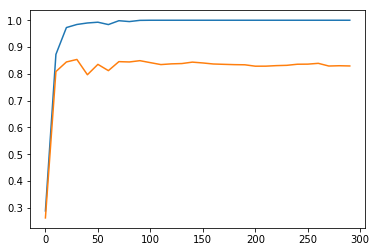

In [9]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_f1'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_f1'])
plt.show()

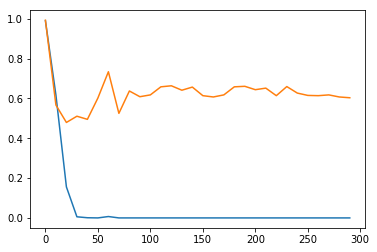

In [10]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_fom'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_fom'])
plt.show()

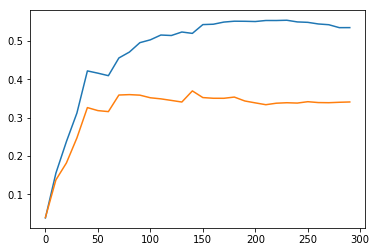

In [11]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_h'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_h'])
plt.show()

## First Vote Only

In [4]:
data = sio.loadmat('/Users/dwright/dev/zoo/machine_augmented_classification/data/snhunters/3pi_20x20_skew2_signPreserveNorm_volunteer_votes_first_only.mat')
y_train  = np.squeeze(data['y']) == 'Yes'                                                                                       
#y_valid  = np.squeeze(data['y_test']) == 'Yes'                                                                                   
data = sio.loadmat('/Users/dwright/dev/zoo/machine_augmented_classification/data/snhunters/3pi_20x20_skew2_signPreserveNorm.mat')
x_train = data['X']
x_valid = data['testX']
y_valid = np.squeeze(data['testy'])

In [5]:
dec = MultitaskDEC(dims=[x_valid.shape[-1], 500, 500, 2000, 10], \
                   n_clusters=n_clusters, batch_size=batch_size)
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x_train)
dec.model.load_weights(dec_weights)

NameError: name 'MultitaskDEC' is not defined

In [ ]:
y_pred, metrics_dict = dec.clustering(x_train, np_utils.to_categorical(y_train), \
                                      (x_valid, np_utils.to_categorical(y_valid)), \
                                      pretrained_weights=dec_weights, maxiter=100)

In [11]:
data = sio.loadmat('/Users/dwright/dev/zoo/machine_augmented_classification/data/snhunters/3pi_20x20_skew2_signPreserveNorm_volunteer_votes_first_only.mat')
human_f1_benchmark = f1_score(y_valid, np.squeeze(data['y_test']) == 'Yes')
print(human_f1_benchmark)

0.7223326706428097


In [ ]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_f1'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_f1'])
plt.plot(metrics_dict['iteration'], human_f1_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
plt.show()

In [ ]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_fom'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_fom'])
plt.show()

In [ ]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_h'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_h'])
plt.show()

## Vote Fraction Analysis

In [12]:
vote_fraction_dict = pickle.load(open('/Users/dwright/dev/zoo/data/supernova-hunters-vote-fraction-dict.pkl', 'rb'))

In [13]:
train_files = []
for f in data['train_files']:
  train_files.append(f.strip().replace('.fits',''))
print(train_files[0])
#train_files = set(train_files)
print(list(set([i for i in train_files if train_files.count(i)>1])))

1170747061421652300_56452.478_26471976_55_diff
['1001246931044034000_56559.503_28601931_52_diff', '1001246931044034000_56559.540_28606628_57_diff', '1001246931044034000_56559.515_28603056_68_diff', '1001246931044034000_56559.527_28604731_58_diff']


In [14]:
valid_files = []
for f in data['test_files']:
  valid_files.append(f.strip().replace('.fits',''))
print(valid_files[0])
#train_files = set(train_files)
print(list(set([i for i in valid_files if valid_files.count(i)>1])))

1140125671321051200_56734.594_31357137_58_diff
['1013335101303600300_56578.525_28830506_29_diff', '1001246931044034000_56569.512_28729009_121_diff', '1001246931044034000_56569.500_28727063_116_diff', '1013335101303600300_56578.536_28832078_27_diff']


In [15]:
vote_fractions_train = []
vote_fractions_valid = []
seen = []
for diff in train_files:
  vote_fractions_train.append(vote_fraction_dict[diff])
  seen.append(diff)
for diff in valid_files:
  vote_fractions_valid.append(vote_fraction_dict[diff])
print(vote_fractions_train[0])
print(vote_fractions_valid[0])
vote_fractions_train = np.array(vote_fractions_train)
vote_fractions_valid = np.array(vote_fractions_valid)

0.03125
0.6190476190476191


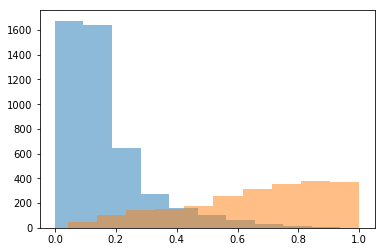

In [16]:
data = sio.loadmat('/Users/dwright/dev/zoo/machine_augmented_classification/data/snhunters/3pi_20x20_skew2_signPreserveNorm.mat')
y_train_true = np.squeeze(data['y'])
bins = [x for x in np.arange(0,1.04,0.04)]
plt.hist(vote_fractions_train[np.where(y_train_true==0)], alpha=0.5)
plt.hist(vote_fractions_train[np.where(y_train_true==1)], alpha=0.5)
plt.show()

In [17]:
y_train_vote_fractions = vote_fractions_train > 0.5
y_valid_vote_fractions = vote_fractions_valid > 0.5

In [18]:
human_vote_fraction_benchmark = f1_score(y_valid, y_valid_vote_fractions)

In [19]:
dec = MultitaskDEC(dims=[x_valid.shape[-1], 500, 500, 2000, 10], \
                   n_clusters=n_clusters, batch_size=batch_size)
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x_train)
dec.model.load_weights(dec_weights)

In [21]:
cluster_centres = get_cluster_centres(dec)
labels = [str(i) for i in range(n_clusters)]

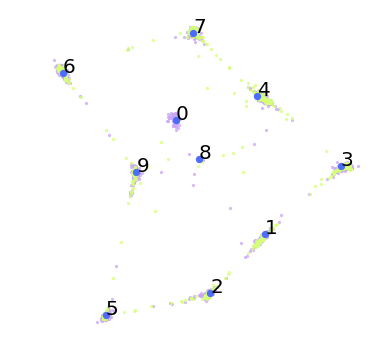

In [22]:
pca_plot(dec.encoder, x_train, cluster_centres, y=y_train, labels=labels, lcolours=[lcolours[0], lcolours[1]])

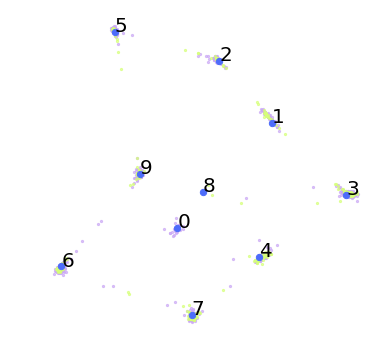

In [23]:
pca_plot(dec.encoder, x_valid, cluster_centres, y=y_valid, labels=labels, lcolours=[lcolours[0], lcolours[1]])

In [24]:
best_mapping_benchmark, _ = get_best_mapping(y_valid, dec.predict_clusters(x_valid), n_clusters, calc_f1_score)

In [25]:
y_pred, metrics_dict = dec.clustering(x_train, np_utils.to_categorical(y_train_vote_fractions), \
                                      (x_valid, np_utils.to_categorical(y_valid)), \
                                      pretrained_weights=dec_weights, maxiter=100, \
                                      alpha=K.variable(1.0), beta=K.variable(0.0), gamma=K.variable(1.0),  \
                                      loss_weight_decay=True)

Update interval 10
Save interval 135.078125
0 117 0 1.0
1 328 0 0.7652439024390244
2 710 0 0.7507042253521127
3 1069 0 0.7567820392890552
4 365 0 0.6876712328767123
5 1673 0 0.6210400478182905
6 1460 0 0.8397260273972603
7 690 0 0.6898550724637681
8 2 0 1.0
9 502 0 0.7071713147410359
[0. 1.] [0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
5
Iter 0  :1% fpr 0.98761 , F1= 0.23834 , F1c= 0.35921 h= 0.03551 ; loss= [0 0 0] ;
 valid 1% fpr=, 0.98303 , valid F1= 0.23321 , valid F1c= 0.35969 h_valid= 0.0398 ; valid_loss=, [1.00892 0.70526 0.0681  0.30365]
saving model:  [inf, inf, inf]  ->  [1.00892 0.70526 0.0681  0.30365]
1.0 0.0 1.0
saving model to: ./results/dec/DEC_model_0.h5
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Iter 10  :1% fpr 0.83037 , F1= 0.76279 , F1c= 0.82329 h= 0.55899 ; loss= [0.44963 0.29106 3.29903 0.15857] ;
 valid 1% fpr=, 0.70496 , valid F1= 0.63884 , valid F1c= 0.73763 h_valid= 0.46411 ; valid_loss=, [0.56925 0.41202 0.12393 0.15723]
saving model:  [1.00892 0.70526 0.0681  0.30365]  ->  [0.56925 0.41202 0.12393 0.15723]
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
Iter 20  :1% fpr 0.30318 , F1= 0.9127 , F1c= 0.91175 h= 0.73535 ; loss= [0.31283 0.1574  0.39575 0.15543] ;
 valid 1% fpr=, 0.75065 , valid F1= 0.74907 , valid F1c= 0.76238 h_valid= 0.4295 ; valid_loss=, [0.57156 0.41551 0.11095 0.15605]
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
Iter 30  :1% fpr 0.79214 , F1= 0.91537 , F1c= 0.91591 h= 0.74736 ; loss= [0.30068 0.14736 0.31989 0.15331] ;
 valid 1% fpr=, 0.82768 , valid F1= 0.76384 , valid F1c= 0.76384 h_valid= 0.40581 ; v

In [26]:
all_ones_benchmark = f1_score(y_valid, np.ones(y_valid.shape))
print(all_ones_benchmark)

0.4991854024112088


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


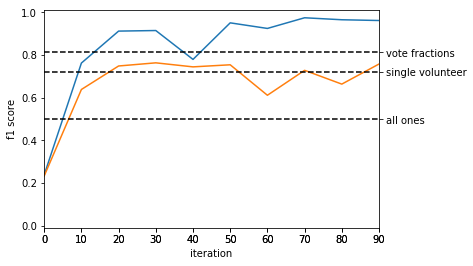

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(metrics_dict['iteration'], metrics_dict['train_f1'], label='train')
ax1.plot(metrics_dict['iteration'], metrics_dict['valid_f1'], label='validation')
ax1.set_xlim(0,metrics_dict['iteration'][-1])
ax1.set_ylim(-0.01,1.01)
ax1.set_xlabel('iteration')
ax1.set_ylabel('f1 score')

ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.plot(metrics_dict['iteration'], human_f1_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.plot(metrics_dict['iteration'], human_vote_fraction_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.plot(metrics_dict['iteration'], all_ones_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.set_xlim(0,metrics_dict['iteration'][-1])
ax2.set_ylim(-0.01,1.01)
ax2.set_yticks([all_ones_benchmark, human_f1_benchmark, human_vote_fraction_benchmark])
ax2.set_yticklabels(['all ones', 'single volunteer', 'vote fractions'])
plt.legend(loc='lower center')
plt.show()

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


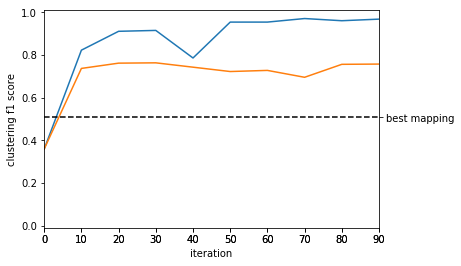

In [43]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(metrics_dict['iteration'], metrics_dict['train_f1c'], label='train')
ax1.plot(metrics_dict['iteration'], metrics_dict['valid_f1c'], label='validation')
ax1.set_xlim(0,metrics_dict['iteration'][-1])
ax1.set_ylim(-0.01,1.01)
ax1.set_xlabel('iteration')
ax1.set_ylabel('clustering f1 score')

ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.plot(metrics_dict['iteration'], best_mapping_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.set_xlim(0,metrics_dict['iteration'][-1])
ax2.set_ylim(-0.01,1.01)
ax2.set_yticks([best_mapping_benchmark])
ax2.set_yticklabels(['best mapping'])
plt.legend(loc='lower center')
plt.show()

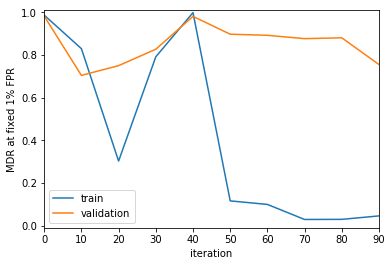

In [29]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_fom'], label='train')
plt.plot(metrics_dict['iteration'], metrics_dict['valid_fom'], label='validation')
plt.xlim(0,metrics_dict['iteration'][-1])
plt.ylim(-0.01,1.01)
plt.xlabel('iteration')
plt.ylabel('MDR at fixed 1% FPR')
plt.legend(loc='lower left')
plt.show()

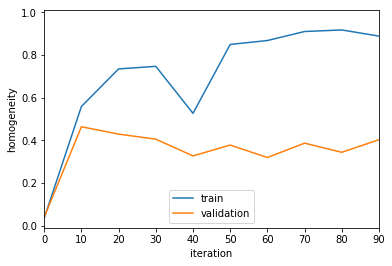

In [30]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_h'], label='train')
plt.plot(metrics_dict['iteration'], metrics_dict['valid_h'], label='validation')
plt.xlim(0,metrics_dict['iteration'][-1])
plt.ylim(-0.01,1.01)
plt.xlabel('iteration')
plt.ylabel('homogeneity')
plt.legend(loc='lower center')
plt.show()

In [31]:
cluster_centres = get_cluster_centres(dec)
labels = [str(i) for i in range(n_clusters)]

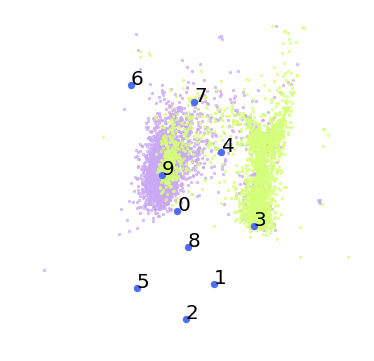

In [32]:
pca_plot(dec.encoder, x_train, cluster_centres, y=y_train, labels=labels, lcolours=[lcolours[0], lcolours[1]])

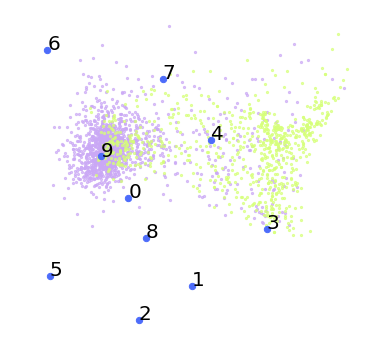

In [33]:
pca_plot(dec.encoder, x_valid, cluster_centres, y=y_valid, labels=labels, lcolours=[lcolours[0], lcolours[1]])